## LSTM Model with Bidirectional Forward and Backward Propagation
- In this part of the project, the focus is on implementing a Long Short-Term Memory (LSTM) model with bidirectional propagation to predict stock prices. LSTM, a type of recurrent neural network (RNN), is highly effective for sequential data tasks, making it ideal for time series predictions such as stock price forecasting.

- The bidirectional propagation enables the model to process stock data both from past to future (forward propagation) and from future to past (backward propagation). By utilizing information from both directions, the model can capture temporal dependencies more comprehensively, learning patterns not only from previous time steps but also considering future context to enhance prediction accuracy.

- The LSTM model is designed to address the vanishing gradient problem, often encountered in traditional RNNs, by maintaining a memory of significant features over time. This memory allows the model to effectively learn and retain long-term dependencies in the time series data, further improving its performance in forecasting stock prices.


In [1]:
# Install Matplotlib for plotting and data visualization
#!pip install matplotlib

# Install Seaborn, a high-level plotting library based on Matplotlib that provides more attractive chart styles
#!pip install seaborn
#!pip install statsmodels

In [2]:
import sys
import warnings
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from datetime import datetime, timedelta
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ignore warning messages (prevent displaying unnecessary warnings)
if not sys.warnoptions:
    warnings.simplefilter('ignore')


### Part 1: Data Preprocessing

#### Purpose：
The purpose of this part is to preprocess the stock data by normalizing the closing prices to a uniform scale. This ensures that the data is well-suited for training the machine learning model, as normalization improves model performance and accelerates convergence during training.

#### Significance:
Preprocessing is a critical step in data analysis, especially for time series forecasting. By using MinMaxScaler to normalize the stock prices, the data values are scaled to a range that enhances the model's ability to learn patterns. This normalization step reduces the potential impact of varying scales, enabling the model to focus on meaningful temporal dependencies in the data.


In [3]:
sns.set()  # Set Seaborn's default style
tf.compat.v1.random.set_random_seed(1234)  # Set random seed for reproducibility

# Read stock data file ('visa_stocks.csv')
df = pd.read_csv('visa_stocks.csv')

# Display the first 5 rows of the data to check its structure
print(df.head())

# Use MinMaxScaler to normalize the closing price (Close index)
# Step 1: Extract the 5th column (index starts from 0, so it's the 4th column) as a specific type (float32) and fit the scaler
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Closing price (Close index)

# Step 2: Apply the fitted scaler to the closing price data for transformation
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Closing price (Close index)

# Convert the normalized data into DataFrame format for easier further processing
df_log = pd.DataFrame(df_log)

# Output the first 5 rows of the normalized data to check the result
print(df_log.head())

         Date       Open       High      Low    Close  Adj Close     Volume
0  2008-03-19  14.875000  17.250000  13.7500  14.1250  12.579995  708486000
1  2008-03-20  14.600000  16.250000  14.3750  16.0875  14.327834  198985200
2  2008-03-24  16.809999  16.924999  14.7500  14.9325  13.299167  149566400
3  2008-03-25  15.145000  16.062500  14.9550  15.8125  14.082910   87092000
4  2008-03-26  15.682500  16.120001  15.3925  15.9900  14.240999   43111600
          0
0  0.012529
1  0.019514
2  0.015403
3  0.018535
4  0.019167


### Part 2: Dataset Splitting

#### Purpose:  
The purpose of this part is to divide the normalized stock price data into a training set and a test set. This division ensures that the model is trained on one portion of the data and evaluated on another, simulating real-world scenarios where future data is unknown during training.

#### Significance:  
Splitting the dataset into training and test sets is essential for evaluating the model's generalization performance. The training set allows the model to learn patterns from historical data, while the test set provides an unbiased assessment of the model's forecasting accuracy on unseen data.


In [4]:
# Define the test set size and simulation size
test_size = 30  # The test set contains 30 samples
simulation_size = 10  # Number of simulation runs

# Split the normalized dataset into training and test sets
df_train = df_log.iloc[:-test_size]  # Training set: from the beginning of the data to the last 30 samples (excluding the last 30)
df_test = df_log.iloc[-test_size:]  # Test set: the last 30 samples

# Output the shape of the entire dataset, as well as the shapes of the training and test sets
df.shape, df_train.shape, df_test.shape

((4177, 7), (4147, 1), (30, 1))

### Part 3: Model Definition and Supporting Functions

#### Purpose:  
The purpose of this part is to define a custom LSTM-based neural network model, along with supporting functions for accuracy calculation and data smoothing. The model incorporates both forward and backward passes, leveraging bidirectional LSTMs to capture sequential dependencies in the data.

#### Significance:  
- The custom LSTM model with multiple layers and dropout ensures robust learning of temporal patterns while mitigating overfitting. By incorporating both forward and backward passes, the model can better capture bidirectional dependencies in time series data, enhancing prediction accuracy.
- The accuracy calculation function provides a metric to evaluate model performance, enabling effective comparison of predictions against actual values.
- The exponential smoothing function aids in reducing noise in the signal, improving the stability and reliability of the predictions. These functionalities collectively enhance the model's effectiveness in forecasting tasks.


In [5]:
# Model definition
class Model(tf.keras.Model):
    def __init__(self, learning_rate, num_layers, size_layer, output_size, forget_bias=0.1):
        """
        Initializes the model with LSTM layers and a dense output layer.

        :param learning_rate: Learning rate for the optimizer.
        :param num_layers: Number of LSTM layers.
        :param size_layer: Number of neurons in each LSTM layer.
        :param output_size: Dimension of the output layer.
        :param forget_bias: Dropout rate to prevent overfitting.
        """
        super(Model, self).__init__()  # Call the parent constructor
        self.size_layer = size_layer  # Number of neurons in each LSTM layer
        self.num_layers = num_layers  # Number of LSTM layers
        # Define LSTM layers with dropout for each layer
        self.lstm_cells = [tf.keras.layers.LSTM(size_layer, return_sequences=True, dropout=forget_bias) for _ in range(num_layers)]
        self.dense = tf.keras.layers.Dense(output_size)  # Fully connected layer for the final prediction
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)  # Adam optimizer

    def call(self, X_forward, X_backward):
        """
        Forward and backward pass through the LSTM layers.

        :param X_forward: Input tensor for the forward pass.
        :param X_backward: Input tensor for the backward pass.
        :return: Predicted logits.
        """
        # Forward pass through LSTM layers
        forward_output = X_forward
        for cell in self.lstm_cells:
            forward_output = cell(forward_output)
        
        # Backward pass through LSTM layers
        backward_output = X_backward
        for cell in self.lstm_cells:
            backward_output = cell(backward_output)

        # Compute the difference between backward and forward outputs
        output = backward_output - forward_output
        logits = self.dense(output[:, -1, :])  # Use the last time step's output for the final prediction
        return logits

# Accuracy calculation function
def calculate_accuracy(real, predict):
    """
    Calculates the accuracy of predictions.

    :param real: Array of true values.
    :param predict: Array of predicted values.
    :return: Accuracy percentage.
    """
    real = np.array(real) + 1  # Shift real values to positive range
    predict = np.array(predict) + 1  # Shift predicted values to positive range
    # Calculate accuracy using error formula
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))  
    return percentage * 100  # Return accuracy as a percentage

# Smoothing function
def anchor(signal, weight):
    """
    Applies exponential smoothing to a signal.

    :param signal: Input signal to be smoothed.
    :param weight: Smoothing weight (0 < weight < 1).
    :return: Smoothed signal as a list.
    """
    buffer = []  # Stores the smoothed signal
    last = signal[0]  # Initialize with the first value
    for i in signal:
        # Compute the smoothed value using the exponential smoothing formula
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)  # Append the smoothed value to the buffer
        last = smoothed_val  # Update the last value for the next iteration
    return buffer  # Return the smoothed signal


### Part 4: Hyperparameter Setup

#### Purpose:
In this section, the hyperparameters for the LSTM model are defined to control the training process and model architecture. These hyperparameters include the number of LSTM layers (`num_layers`), the size of the hidden layer (`size_layer`), the length of the input sequence (`timestamp`), the number of training epochs (`epoch`), the dropout rate (`dropout_rate`), the number of days to predict (`future_day`), and the learning rate (`learning_rate`). These parameters are essential for fine-tuning the model's performance and determining how the model will process the data and adjust during training.

#### Significance:
The significance of setting appropriate hyperparameters is crucial for achieving optimal model performance. The number of LSTM layers and units per layer influences the model’s ability to capture complex temporal patterns in the data. The `timestamp` defines the temporal context of the input sequence, affecting how much past information the model uses to make predictions. The `dropout_rate` helps prevent overfitting by randomly "dropping" a percentage of neurons during training. The `epoch` controls the duration of training, determining how many times the model will be exposed to the data. The learning rate controls how quickly the model adjusts its parameters during training, which is critical for convergence and preventing overshooting. Setting these hyperparameters correctly allows the model to efficiently learn from the training data and make accurate predictions for future stock prices.


In [6]:
# Set the hyperparameters for the model
num_layers = 1           # Number of LSTM layers
size_layer = 128         # Number of units in each LSTM layer (size of the hidden layer)
timestamp = 5            # Time steps (length of the input sequence)
epoch = 10               # Number of training iterations (epochs)
dropout_rate = 0.8       # Retention rate of the Dropout layer (to prevent overfitting)
future_day = test_size   # Number of future days to predict, equal to the size of the test set
learning_rate = 0.01     # Learning rate, controls the step size for the optimizer's parameter updates

### Part 5: Model Training and Prediction

#### Purpose:
The purpose of this section is to define the process of training the custom LSTM-based model and using it to make predictions. The `create_model` function initializes the model, the `train_model` function trains the model on the provided dataset, and the `predict` function generates future predictions based on the trained model. The `forecast` function combines these processes to produce the final predictions for future time steps.

#### Significance:
This part is critical for training the model and generating predictions. The key functions involved are:

- **`create_model`**: This function initializes and clears the TensorFlow session to ensure that a fresh model is created each time. It sets up the LSTM model with the predefined hyperparameters, ensuring that the architecture is consistent with the required parameters such as the learning rate, number of layers, and size of the hidden layer.

- **`train_model`**: This function is responsible for training the LSTM-based model using the provided training dataset. It iterates through the dataset in batches, performing forward and backward passes, calculating the loss, and updating the model parameters via gradient descent. The training loop also tracks the loss and accuracy during each epoch, providing feedback to ensure the model is improving.

- **`predict`**: This function generates predictions for future time steps. It first predicts on the training data and then extrapolates these predictions beyond the training set. The model uses both forward and backward passes to generate predictions, and smoothing techniques (like exponential smoothing) are applied to improve the stability of the forecast.

- **`forecast`**: This function ties everything together. It calls the `create_model` function to initialize the model, trains the model using `train_model`, and finally generates predictions using the `predict` function. The output of this function is the forecasted future values, which are critical for time-series forecasting tasks such as predicting stock prices or other temporal data.

Each of these functions plays an essential role in ensuring that the model is properly trained, optimized, and used to generate accurate predictions. The integration of these functions facilitates a streamlined process for time-series forecasting.


In [7]:
def create_model():
    """
    Initialize and clear the TensorFlow session to create a fresh model.

    Returns:
        Model: The initialized custom LSTM-based model.
    """
    K.clear_session()  # Clear the current TensorFlow session to avoid conflicts.

    # Initialize the custom model with predefined parameters.
    modelnn = Model(learning_rate, num_layers, size_layer, df_log.shape[1], dropout_rate)
    
    return modelnn

def train_model(modelnn, df_train, epoch, timestamp):
    """
    Train the custom model using the training dataset.

    Args:
        modelnn (Model): The LSTM-based model to train.
        df_train (DataFrame): The training dataset containing time-series data.
        epoch (int): Number of training epochs.
        timestamp (int): Length of the input sequence for each batch.

    Returns:
        Model: The trained model.
    """
    pbar = tqdm(range(epoch), desc='Training Loop')  # Display a progress bar for training.
    
    for i in pbar:
        # Initialize the forward and backward state arrays for the LSTM model.
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        
        total_loss, total_acc = [], []  # Track loss and accuracy across batches.

        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            
            # Prepare the input data for forward and backward passes.
            batch_x_forward = np.expand_dims(df_train.iloc[k: index, :].values, axis=0)
            batch_x_backward = np.expand_dims(np.flip(df_train.iloc[k: index, :].values, axis=0), axis=0)
            batch_y = df_train.iloc[k + 1: index + 1, :].values

            # Compute gradients and update model weights.
            with tf.GradientTape() as tape:
                logits = modelnn(batch_x_forward, batch_x_backward)
                mse_loss = tf.keras.losses.MeanSquaredError()
                loss = mse_loss(batch_y, logits)

            gradients = tape.gradient(loss, modelnn.trainable_variables)
            modelnn.optimizer.apply_gradients(zip(gradients, modelnn.trainable_variables))

            total_loss.append(loss.numpy())
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))

        # Update the progress bar with the latest loss and accuracy.
        pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

    return modelnn

def predict(modelnn, df_train, test_size, timestamp):
    """
    Generate predictions using the trained model.

    Args:
        modelnn (Model): The trained LSTM-based model.
        df_train (DataFrame): The training dataset for reference during prediction.
        test_size (int): Number of future time steps to predict.
        timestamp (int): Length of the input sequence for each batch.

    Returns:
        np.array: The predicted future values.
    """
    # Initialize the output array for storing predictions.
    future_day = test_size
    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]

    upper_b = (df_train.shape[0] // timestamp) * timestamp

    # Predict on the training dataset.
    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(df_train.iloc[k: k + timestamp, :], axis=0)
        batch_x_backward = np.expand_dims(np.flip(df_train.iloc[k: k + timestamp, :].values, axis=0), axis=0)
        out_logits = modelnn(batch_x_forward, batch_x_backward)
        output_predict[k + 1: k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis=0)
        batch_x_backward = np.expand_dims(np.flip(df_train.iloc[upper_b:, :].values, axis=0), axis=0)
        out_logits = modelnn(batch_x_forward, batch_x_backward)
        output_predict[upper_b + 1: df_train.shape[0] + 1] = out_logits
        future_day -= 1

    # Predict future values beyond the training dataset.
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i: -future_day + i]
        o_f = np.flip(o, axis=0)
        out_logits = modelnn(np.expand_dims(o, axis=0), np.expand_dims(o_f, axis=0))
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days=1))

    # Post-process predictions (inverse scaling and smoothing).
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

def forecast():
    """
    Train the model and forecast future values.

    Returns:
        np.array: The predicted future values.
    """
    modelnn = create_model()  # Create the LSTM-based model.
    modelnn = train_model(modelnn, df_train, epoch, timestamp)  # Train the model.
    forecast_result = predict(modelnn, df_train, test_size, timestamp)  # Generate predictions.

    return forecast_result


### Part 6: Simulation and Performance Evaluation

#### Purpose:
The purpose of this section is to run multiple simulations of the forecasting model and evaluate its performance in terms of prediction accuracy and execution time. The code runs a loop where the `forecast` function is called multiple times, and for each simulation, the prediction results are stored, and the time taken for each simulation is recorded. This allows for performance tracking and comparison across different runs of the model.

#### Significance:
This part is essential for assessing the efficiency and scalability of the forecasting model. The key elements are:

- **Simulation Loop**: The loop runs the forecasting process multiple times (specified by `simulation_size`). Each iteration of the loop represents a separate simulation where the model makes a prediction using the `forecast` function. This enables us to assess the model's consistency and reliability by averaging results from multiple runs.

- **Performance Tracking**: The time taken for each simulation is recorded using the `time` module, providing insight into how long each forecast takes to compute. By tracking this duration, we can assess whether the model is computationally efficient or if further optimizations are needed, especially for larger datasets.

- **Results Storage**: The `results` list stores the forecasted values for each simulation, allowing for post-simulation analysis. These results can be further analyzed to evaluate the model's accuracy or compared to ground truth data if available.

- **Efficiency Evaluation**: By printing the duration of each simulation, the process provides immediate feedback on the computational time per simulation. This helps to identify potential bottlenecks and allows us to make adjustments to improve model performance or reduce execution time.


In [8]:
# Initialize an empty list to store the results of each simulation's forecast
results = []

# Initialize an empty list to store the duration of each simulation run (in seconds)
simulation_times = []

# Start a loop to run multiple simulations (simulation_size defines how many times to run)
for i in range(simulation_size):
    start_time = time.time()  # Record the current time as the start time of the simulation
    print(f"simulation {i + 1} started")  # Print a message indicating the start of the simulation

    # Call the forecast() function to perform the forecast and store the result in forecast_result
    forecast_result = forecast()

    # Append the forecast result to the results list for later use or analysis
    results.append(forecast_result)

    end_time = time.time()  # Record the current time as the end time of the simulation
    simulation_duration = end_time - start_time  # Calculate the time it took to complete this simulation (in seconds)

    # Append the simulation duration to the simulation_times list for later analysis
    simulation_times.append(simulation_duration)

    # Print a message indicating that the simulation has completed, along with the time it took to run
    print(f"simulation {i + 1} completed in {simulation_duration:.2f} seconds")


simulation 1 started


Training Loop: 100%|█████| 10/10 [01:55<00:00, 11.50s/it, acc=96.7, cost=0.0113]


simulation 1 completed in 120.82 seconds
simulation 2 started


Training Loop: 100%|█████| 10/10 [01:56<00:00, 11.67s/it, acc=96.7, cost=0.0113]


simulation 2 completed in 122.59 seconds
simulation 3 started


Training Loop: 100%|█████| 10/10 [01:56<00:00, 11.64s/it, acc=96.7, cost=0.0113]


simulation 3 completed in 122.19 seconds
simulation 4 started


Training Loop: 100%|█████| 10/10 [01:57<00:00, 11.71s/it, acc=96.7, cost=0.0113]


simulation 4 completed in 122.91 seconds
simulation 5 started


Training Loop: 100%|█████| 10/10 [01:58<00:00, 11.81s/it, acc=96.7, cost=0.0113]


simulation 5 completed in 123.89 seconds
simulation 6 started


Training Loop: 100%|█████| 10/10 [01:58<00:00, 11.84s/it, acc=96.7, cost=0.0113]


simulation 6 completed in 124.14 seconds
simulation 7 started


Training Loop: 100%|█████| 10/10 [01:58<00:00, 11.90s/it, acc=96.7, cost=0.0113]


simulation 7 completed in 124.74 seconds
simulation 8 started


Training Loop: 100%|█████| 10/10 [01:58<00:00, 11.82s/it, acc=96.7, cost=0.0113]


simulation 8 completed in 123.92 seconds
simulation 9 started


Training Loop: 100%|█████| 10/10 [01:57<00:00, 11.75s/it, acc=96.7, cost=0.0113]


simulation 9 completed in 123.26 seconds
simulation 10 started


Training Loop: 100%|█████| 10/10 [01:59<00:00, 11.92s/it, acc=96.7, cost=0.0113]


simulation 10 completed in 124.98 seconds


### Part 7: Data Visualization

#### Purpose:
The purpose of this code is to evaluate and visualize the accuracy of multiple forecast results compared to the actual closing prices of a stock. After calculating the accuracy of each forecast, it plots both the forecasted stock prices and the true stock price trend. The plot also includes a title displaying the average accuracy of all forecasts, which provides a visual comparison of the model’s prediction accuracy over multiple simulations.

#### Significance:
- **Accuracy Assessment**: By calculating the accuracy of each forecast compared to the true closing prices, the code provides a quantitative evaluation of the forecasting model's performance. This allows for a clear understanding of how well the model can predict future stock prices and whether it is suitable for real-world applications.

- **Model Comparison**: Plotting multiple forecast results on the same graph allows for an easy comparison of different forecasts generated in the simulations. This comparison helps to identify patterns, trends, or discrepancies in the model's predictions, guiding further refinement or adjustment of the model.

- **Visual Representation**: The plot offers a clear visual representation of the stock price trends, helping stakeholders, analysts, or data scientists to visually assess the model's predictive power. Including the true stock price trend in red provides a benchmark for performance evaluation, making it easier to interpret how closely the model’s forecasts match the actual data.

- **Model Improvement**: The average accuracy displayed in the title of the plot provides an overall measure of the model’s effectiveness across simulations, offering valuable insights for improving the model. If the accuracy is not satisfactory, it indicates the need for model adjustments or additional feature engineering to enhance prediction accuracy.


# Plots

## Plot 1: Comparison of Forecasted Stock Prices vs. True Trend with Accuracy Evaluation

**Purpose:**  
To compare the forecasted stock price trends from multiple simulations against the actual true stock price trend and visualize the accuracy of each forecast. The plot aims to evaluate how well the forecasted trends match the true stock prices over the test period.

**Significance:**  
This visualization provides insight into the performance of the forecast model(s) and the reliability of predictions. By plotting the forecast results alongside the true stock prices, it allows for a clear visual comparison and quantifies the accuracy of each forecast, which can inform decisions regarding the effectiveness of the forecasting model.

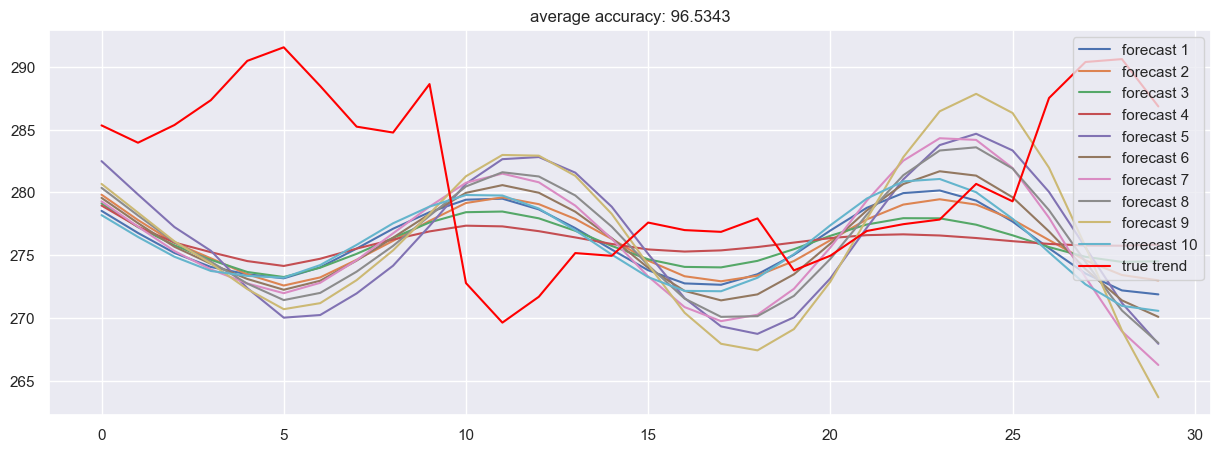

In [9]:
# Calculate the accuracy of each forecast result compared to the true closing prices
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Create a plot with a size of 15x5 inches
plt.figure(figsize = (15, 5))

# Plot each forecast result with a label indicating its forecast number
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d' % (no + 1))

# Plot the true stock price trend in red
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'red')

# Display the legend to label each line in the plot
plt.legend()

# Set the plot title with the average accuracy of all forecasts
plt.title('average accuracy: %.4f' % (np.mean(accuracies)))

# Display the plot
plt.show()

## Plot 2: True vs Predicted Stock Price

**Purpose:**  
To compare the true stock prices against the predicted stock prices for the last 'test_size' days, visually highlighting the accuracy of the forecast model over a specified period.

**Significance:**  
This plot serves to assess how closely the predicted stock prices align with the actual prices. By displaying both the true and predicted values, it provides a clear visual indication of the model's forecasting performance, helping to identify any discrepancies or trends in the predictions.


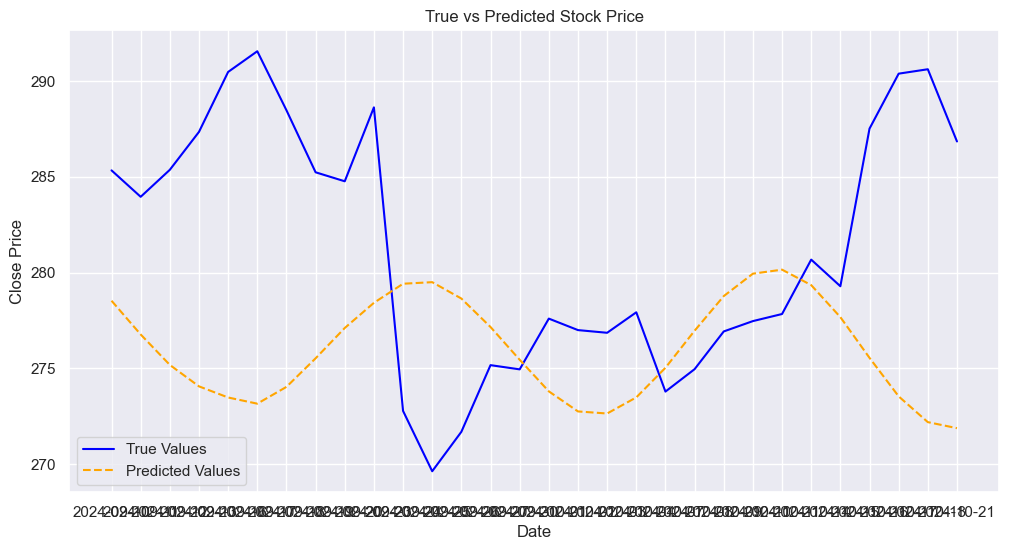

In [10]:
# Create a figure with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Plot the true values of the stock price for the last 'test_size' days with blue color
plt.plot(df['Date'][-test_size:], df['Close'][-test_size:], label='True Values', color='blue')

# Plot the predicted values of the stock price for the last 'test_size' days with orange color and dashed line style
plt.plot(df['Date'][-test_size:], results[0], label='Predicted Values', color='orange', linestyle='--')

# Set the title of the plot
plt.title('True vs Predicted Stock Price')

# Label the x-axis as 'Date'
plt.xlabel('Date')

# Label the y-axis as 'Close Price'
plt.ylabel('Close Price')

# Display the legend to identify true and predicted values
plt.legend()

# Display the plot
plt.show()

## Plot 3: Simulations of Forecast

**Purpose:**  
To display the results of multiple forecast simulations, highlighting the variation in predictions and showcasing the mean prediction along with the standard deviation at each time step. The plot allows for visualizing the spread and consistency of the forecast results.

**Significance:**  
This plot is important for assessing the uncertainty and variability in the model's predictions. By showing individual simulation results, the mean prediction, and the range defined by one standard deviation, it helps to understand the model's robustness and reliability in forecasting over time.


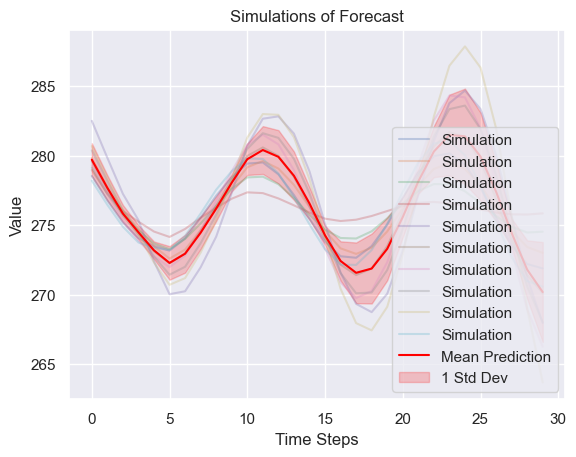

In [11]:
# Convert the list of prediction results to a NumPy array for easier computation
predictions_array = np.array(results)

# Calculate the mean of the predictions at each time step across all simulations
mean_result = np.mean(predictions_array, axis=0)

# Calculate the standard deviation of the predictions at each time step across all simulations
std_result = np.std(predictions_array, axis=0)

# Loop through each result in the simulation results and plot them with reduced opacity for distinction
for result in results:
    plt.plot(result, alpha=0.3, label='Simulation')  # Set transparency for distinguishing multiple simulations

# Plot the mean of the predictions as a red line
plt.plot(mean_result, color='red', label='Mean Prediction')

# Fill the area between mean - standard deviation and mean + standard deviation with red color and transparency
plt.fill_between(range(len(mean_result)), 
                 mean_result - std_result, 
                 mean_result + std_result, 
                 color='red', alpha=0.2, label='1 Std Dev')

# Add a legend to identify different plot elements
plt.legend()

# Set the title of the plot
plt.title('Simulations of Forecast')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'Value'
plt.ylabel('Value')

# Display the plot
plt.show()


## Plot 4: True vs Predicted Values (Multiple Simulations)

**Purpose:**  
To compare the true stock prices with the mean of multiple forecast predictions, highlighting the accuracy of the model's predictions over time. The plot also includes a confidence interval based on the standard deviation of the predictions, providing a visual indication of uncertainty.

**Significance:**  
This plot is significant for evaluating how well the forecast model performs against real data, showing both the mean predicted values and the variability across different simulations. The confidence interval helps to assess the consistency of the predictions, giving insights into the model's reliability and uncertainty.


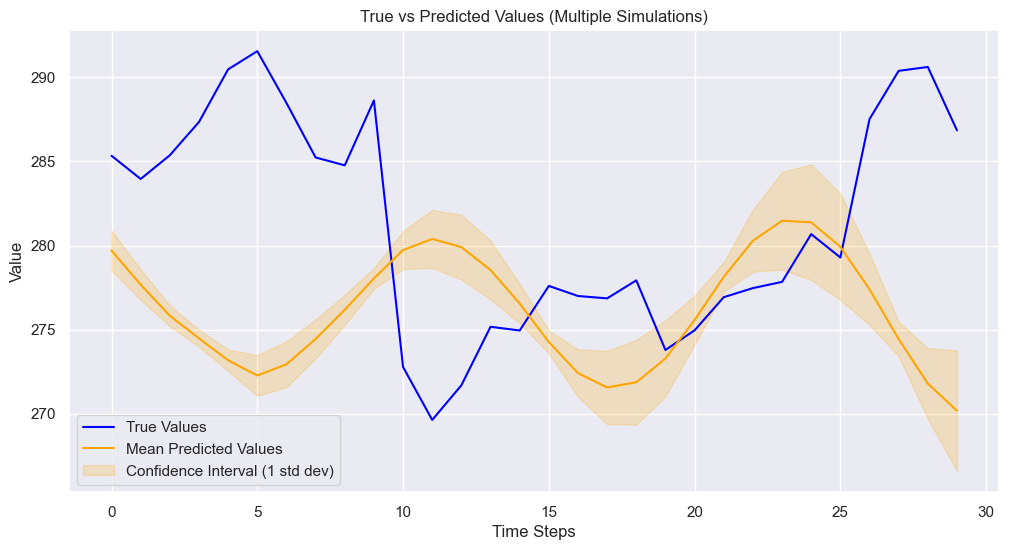

In [12]:
# Extract the true closing prices for the last 'test_size' number of steps
true_values = df['Close'].iloc[-test_size:].values

# Convert the list of prediction results to a NumPy array for easier computation
predictions_array = np.array(results)

# Calculate the mean of the predictions at each time step across all simulations
mean_prediction = np.mean(predictions_array, axis=0)

# Calculate the standard deviation of the predictions at each time step across all simulations
std_prediction = np.std(predictions_array, axis=0)

# Create a plot with a specified size
plt.figure(figsize=(12, 6))

# Plot the true values as a blue line
plt.plot(true_values, label='True Values', color='blue')

# Plot the mean predicted values as an orange line
plt.plot(mean_prediction, label='Mean Predicted Values', color='orange')

# Fill the area between the mean prediction minus standard deviation and the mean prediction plus standard deviation
# to represent the confidence interval with orange color and 20% transparency
plt.fill_between(range(len(mean_prediction)),
                 mean_prediction - std_prediction,
                 mean_prediction + std_prediction,
                 color='orange', alpha=0.2, label='Confidence Interval (1 std dev)')

# Set the title of the plot
plt.title('True vs Predicted Values (Multiple Simulations)')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'Value'
plt.ylabel('Value')

# Display the legend to explain the plot labels
plt.legend()

# Show the plot
plt.show()


## Plot 5: Residuals Over Time

**Purpose:**  
To visualize the residuals (differences) between the true stock prices and the mean predicted values over time. This plot helps in assessing how well the forecast model is performing by examining the errors in the predictions at each time step.

**Significance:**  
This plot is significant for understanding the model's prediction accuracy. Residuals close to zero indicate that the model's predictions are accurate, while large deviations suggest poor model performance. The horizontal line at y=0 serves as a baseline, making it easier to identify systematic errors and trends in the residuals.


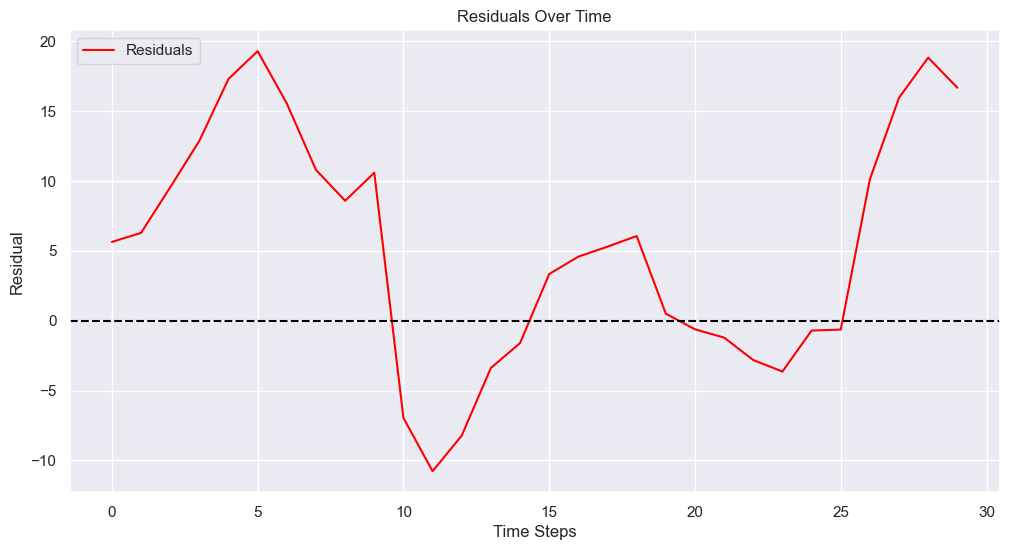

In [13]:
# Assign the mean predicted values to a variable for residual calculation
predicted_values = mean_prediction

# Calculate the residuals (differences between the true values and predicted values)
residuals = true_values - predicted_values

# Create a plot with a specified size
plt.figure(figsize=(12, 6))

# Plot the residuals as a red line
plt.plot(residuals, label='Residuals', color='red')

# Add a horizontal line at y=0 to represent the baseline for residuals (where the error is zero)
plt.axhline(y=0, color='black', linestyle='--')

# Set the title of the plot
plt.title('Residuals Over Time')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'Residual'
plt.ylabel('Residual')

# Display the legend to explain the plot labels
plt.legend()

# Show the plot
plt.show()


## Plot 6: Residual Distribution

**Purpose:**  
To visualize the distribution of residuals (the differences between the true values and predicted values). The plot includes a histogram and a kernel density estimate (KDE), which helps in understanding the spread and underlying distribution of prediction errors.

**Significance:**  
This plot is significant for diagnosing the model's performance. A well-behaved residual distribution (e.g., centered around zero and normally distributed) indicates that the model's errors are randomly distributed, suggesting a good model fit. Conversely, any skewness or patterns in the residuals may suggest that the model has some bias or systematic errors.


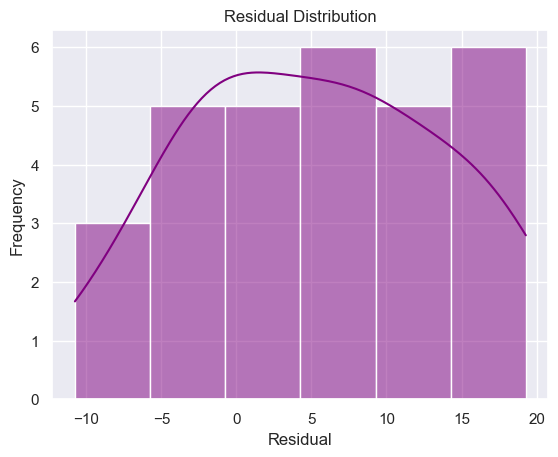

In [14]:
# Create a histogram with a kernel density estimate (KDE) for the residuals, using purple color
sns.histplot(residuals, kde=True, color='purple')

# Set the title of the plot
plt.title('Residual Distribution')

# Label the x-axis as 'Residual'
plt.xlabel('Residual')

# Label the y-axis as 'Frequency'
plt.ylabel('Frequency')

# Display the plot
plt.show()

## Plot 7: RMSE Over Time Steps

**Purpose:**  
To visualize the Root Mean Square Error (RMSE) at each time step across all simulations. RMSE provides an aggregate measure of the model's prediction error, helping to evaluate the model's accuracy over time.

**Significance:**  
This plot is significant for assessing the model's performance over the entire forecasting period. A lower RMSE indicates better accuracy in predictions, while higher RMSE values highlight time steps where the model's predictions deviate more from the true values. Tracking RMSE over time helps identify trends in model error, such as periods of higher or lower prediction accuracy.


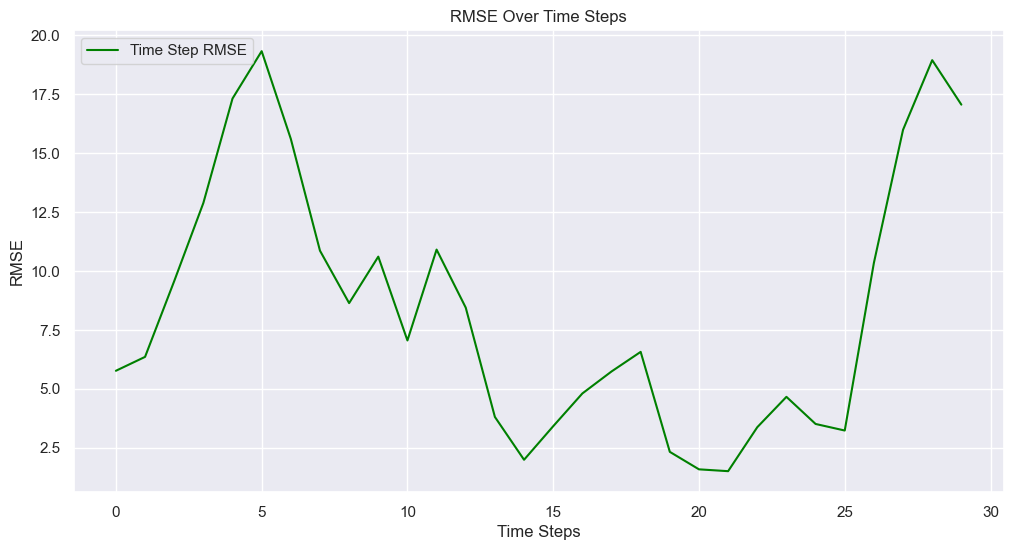

In [15]:
# Calculate the RMSE (Root Mean Square Error) for each time step
time_step_rmse = np.sqrt(np.mean((predictions_array - true_values)**2, axis=0))

# Create a figure for the plot with specified size
plt.figure(figsize=(12, 6))

# Plot the RMSE values over time steps, labeled as 'Time Step RMSE' and colored green
plt.plot(time_step_rmse, label='Time Step RMSE', color='green')

# Set the title of the plot
plt.title('RMSE Over Time Steps')

# Label the x-axis as 'Time Steps'
plt.xlabel('Time Steps')

# Label the y-axis as 'RMSE'
plt.ylabel('RMSE')

# Display the legend on the plot
plt.legend()

# Show the plot
plt.show()


## Plot 8: Autocorrelation and Partial Autocorrelation Plots

**Purpose:**  
To analyze the temporal dependencies in the stock price data by plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) with 30 lags. The ACF helps to understand the overall correlation between the stock prices at different time lags, while the PACF identifies the direct relationship between the current and lagged values after removing the effects of intervening lags.

**Significance:**  
These plots are significant in identifying the underlying structure of the time series data. The ACF helps detect long-term dependencies in the data, which is useful for identifying trends and seasonal patterns. The PACF is particularly useful in identifying the order of autoregressive (AR) models when building time series forecasting models. Both ACF and PACF are essential tools for model selection and understanding the autocorrelations in stock price movements.


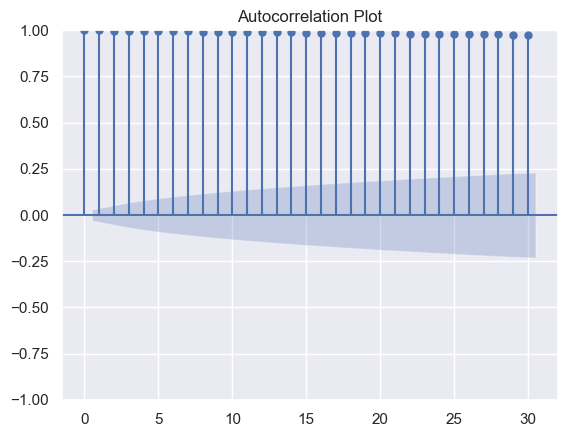

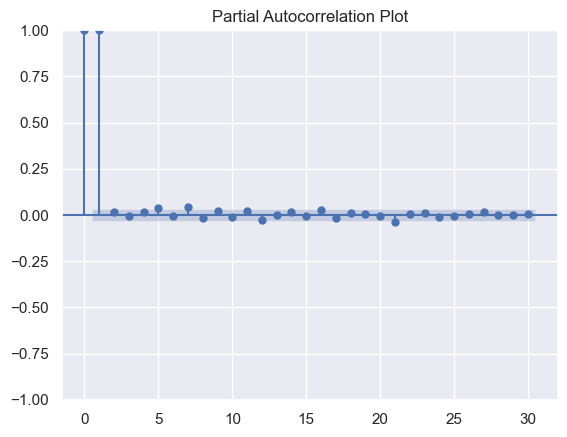

In [16]:
# Plot the Autocorrelation Function (ACF) for the 'Close' column with 30 lags
plot_acf(df['Close'], lags=30)

# Set the title for the Autocorrelation Plot
plt.title('Autocorrelation Plot')

# Display the Autocorrelation plot
plt.show()

# Plot the Partial Autocorrelation Function (PACF) for the 'Close' column with 30 lags
plot_pacf(df['Close'], lags=30)

# Set the title for the Partial Autocorrelation Plot
plt.title('Partial Autocorrelation Plot')

# Display the Partial Autocorrelation plot
plt.show()


## Plot 9: Smoothed Predicted vs True Stock Price

**Purpose:**  
To compare the smoothed predicted stock prices against the true stock prices. The smoothing technique applied to the predicted values helps reduce noise and make the forecast more stable, enabling a clearer comparison with the actual stock price trend.

**Significance:**  
This plot is significant because it demonstrates how smoothing can improve the clarity and accuracy of predictions, especially in volatile time series data like stock prices. By reducing the fluctuations in the predictions, the smoothed values provide a more reliable representation of future trends, helping to assess the model’s effectiveness and forecasting ability.


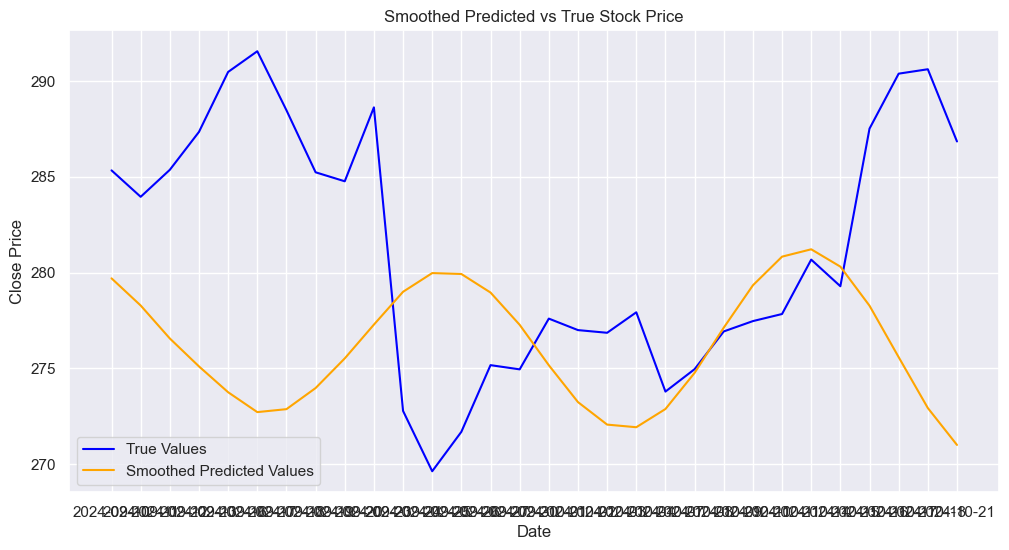

In [17]:
# Apply smoothing to the mean prediction using the anchor function with a smoothing factor of 0.3
smoothed_prediction = anchor(mean_prediction, 0.3)

# Create a figure for the plot with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Plot the true values ('Close') for the last 'test_size' dates, in blue
plt.plot(df['Date'][-test_size:], df['Close'][-test_size:], label='True Values', color='blue')

# Plot the smoothed predicted values for the last 'test_size' dates, in orange
plt.plot(df['Date'][-test_size:], smoothed_prediction, label='Smoothed Predicted Values', color='orange')

# Set the title of the plot
plt.title('Smoothed Predicted vs True Stock Price')

# Set the x-axis label as 'Date'
plt.xlabel('Date')

# Set the y-axis label as 'Close Price'
plt.ylabel('Close Price')

# Display the legend to differentiate between true values and smoothed predictions
plt.legend()

# Display the plot
plt.show()


## Plot 10: Daily Percentage Change (True vs Predicted)

**Purpose:**  
To compare the daily percentage changes in the true stock prices with the predicted percentage changes. This plot illustrates how well the model’s predictions capture the daily fluctuations in stock prices.

**Significance:**  
This plot is significant because it highlights the model's ability to track the dynamics of stock price movements. By comparing the true and predicted percentage changes, it provides insight into the model's accuracy in forecasting short-term price variations, which is essential for trading strategies and risk management. The rolling average also smooths out short-term volatility, helping to assess overall trend-following performance.

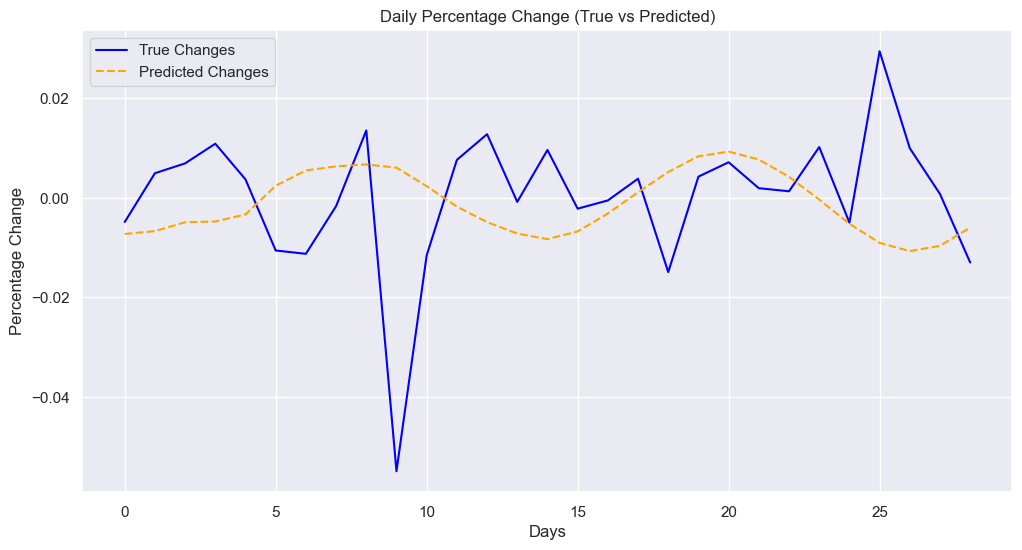

In [18]:
# Calculate the percentage changes in the true values of 'Close' for the last 'test_size' days
true_changes = np.diff(df['Close'][-test_size:]) / df['Close'][-test_size:][:-1]

# Calculate the percentage changes in the predicted values (mean prediction)
pred_changes = np.diff(mean_prediction) / mean_prediction[:-1]

# Compute the 7-day rolling average of the true changes using pandas rolling method
rolling_true = pd.Series(true_changes).rolling(window=7).mean()

# Compute the 7-day rolling average of the predicted changes using pandas rolling method
rolling_pred = pd.Series(pred_changes).rolling(window=7).mean()

# Create a figure for the plot with a size of 12x6 inches
plt.figure(figsize=(12, 6))

# Plot the true percentage changes (calculated earlier) with the x-axis representing the range of days and color it blue
plt.plot(range(len(true_changes)), true_changes, label='True Changes', color='blue')

# Plot the predicted percentage changes (calculated earlier) with the x-axis representing the range of days and color it orange with dashed lines
plt.plot(range(len(pred_changes)), pred_changes, label='Predicted Changes', color='orange', linestyle='--')

# Set the title of the plot
plt.title('Daily Percentage Change (True vs Predicted)')

# Set the x-axis label as 'Days'
plt.xlabel('Days')

# Set the y-axis label as 'Percentage Change'
plt.ylabel('Percentage Change')

# Display the legend to differentiate between true and predicted changes
plt.legend()

# Display the plot
plt.show()
